In [89]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import psycopg2
from sqlalchemy import create_engine
import os

The numeration of the sections below is made to match the report's sections

# 2. Feature engineering 

### Datasets import and export

In [90]:
#Import with separator specification
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')
x_test = pd.read_csv('x_test.csv')
x_test_add = pd.read_csv('additional_x_files_2EHFvuq/x_test_additional_file.csv')
x_train_add = pd.read_csv('additional_x_files_2EHFvuq/x_train_additional_file.csv')

#Spaces deletion in columns names
x_train.columns = [x.strip().replace(' ', '_') for x in x_train.columns]
x_test.columns = [x.strip().replace(' ', '_') for x in x_test.columns]
y_train.columns = [x.strip().replace(' ', '_') for x in y_train.columns]
x_train_add.columns = [x.strip().replace(' ', '_') for x in x_train_add.columns]
x_test_add.columns = [x.strip().replace(' ', '_') for x in x_test_add.columns]

x_test_init=x_test

In [91]:
x_train.head()

,emergency_vehicle_selection,intervention,alert_reason_category,alert_reason,intervention_on_public_roads,floor,location_of_the_event,longitude_intervention,latitude_intervention,emergency_vehicle,...,delta_status_preceding_selection-selection,departed_from_its_rescue_center,longitude_before_departure,latitude_before_departure,delta_position_gps_previous_departure-departure,GPS_tracks_departure-presentation,GPS_tracks_datetime_departure-presentation,OSRM_response,OSRM_estimated_distance,OSRM_estimated_duration
0,5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,...,2027,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8
1,4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,...,28233,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2
2,5365374,13675521,3,2163,0,2,139.0,2.258328,48.836759,4509,...,1981,0,2.272944,48.850498,33.0,"2.272972,48.850498;2.269056,48.847443;2.262611...",2018-11-16 10:14:31;2018-11-16 10:15:43;2018-1...,"{""code"":""Ok"",""routes"":[{""geometry"":""_cdiHo}zLm...",3026.4,295.4
3,4741586,12695745,3,2162,0,0,136.0,2.393832,48.776526,5731,...,1842,1,2.388940,48.787732,NaN,"2.394278,48.782112;2.393639,48.776833",2018-01-15 00:42:46;2018-01-15 00:43:58,"{""code"":""Ok"",""routes"":[{""geometry"":""sywhH_pqMy...",1934.2,166.6
4,5381209,13698743,3,2162,0,3,104.0,2.458610,48.875751,5623,...,2716,1,2.439331,48.863814,NaN,"2.439472,48.863724;2.439583,48.863777;2.440917...",2018-11-24 00:37:10;2018-11-24 00:38:22;2018-1...,"{""code"":""Ok"",""routes"":[{""geometry"":""wvfiHgn{Mj...",2706.7,262.6


In [92]:
x_train.columns

Index(['emergency_vehicle_selection', 'intervention', 'alert_reason_category',
       'alert_reason', 'intervention_on_public_roads', 'floor',
       'location_of_the_event', 'longitude_intervention',
       'latitude_intervention', 'emergency_vehicle', 'emergency_vehicle_type',
       'rescue_center', 'selection_time', 'date_key_sélection',
       'time_key_sélection', 'status_preceding_selection',
       'delta_status_preceding_selection-selection',
       'departed_from_its_rescue_center', 'longitude_before_departure',
       'latitude_before_departure',
       'delta_position_gps_previous_departure-departure',
       'GPS_tracks_departure-presentation',
       'GPS_tracks_datetime_departure-presentation', 'OSRM_response',
       'OSRM_estimated_distance', 'OSRM_estimated_duration'],
      dtype='object')

### OSRM estimated duration update with additionnal data

In [93]:
### For the training sample :
# Update of the estimated arrival time and addition of a feature named 'updated', 
# With a value of 1 if the time has changed, 0 otherwise

updated=np.zeros(x_train['OSRM_estimated_duration'].shape)
updated=np.isnan(x_train_add['updated_OSRM_estimated_duration']) # 1 if nan, 0 otherwise

# Treating NaN values
x_train['OSRM_estimated_duration']=updated*x_train['OSRM_estimated_duration']+np.nan_to_num(x_train_add['updated_OSRM_estimated_duration'])
x_train.loc[:, 'updated'] = 1*np.invert(updated) # 1 if new time, 0 otherwise

### For the testing sample :
updated=np.zeros(x_test['OSRM_estimated_duration'].shape)
updated=np.isnan(x_test_add['updated_OSRM_estimated_duration']) ### 1 if nan, 0 otherwise

x_test['OSRM_estimated_duration']=updated*x_test['OSRM_estimated_duration']+np.nan_to_num(x_test_add['updated_OSRM_estimated_duration'])
x_test.loc[:, 'updated'] = 1*np.invert(updated) # 1 if new time, 0 otherwise

### Converting dates to integers

In [94]:
x_train['selection_time'].head()

0    2018-07-08 19:02:43.990
1    2018-01-04 09:02:59.470
2    2018-11-16 10:11:47.777
3    2018-01-15 00:38:46.820
4    2018-11-24 00:34:26.017
Name: selection_time, dtype: object

In [95]:
# String to datetime
x_train['selection_time'] = pd.to_datetime(x_train.selection_time)
x_test['selection_time'] = pd.to_datetime(x_test.selection_time)

# Adding year, month, hour and day of week as features
x_train.loc[:, 'date'] = x_train['selection_time'].dt.date
x_train.loc[:, 'hour'] = x_train['selection_time'].dt.hour
x_test.loc[:, 'date'] = x_test['selection_time'].dt.date
x_test.loc[:, 'hour'] = x_test['selection_time'].dt.hour
x_train.loc[:, 'month'] = x_train['selection_time'].dt.month
x_test.loc[:, 'month'] = x_test['selection_time'].dt.month
x_train.loc[:, 'dayofweek'] = x_train['selection_time'].dt.dayofweek
x_test.loc[:, 'dayofweek'] = x_test['selection_time'].dt.dayofweek

In [96]:
# Final check for mistakes :
print(len(x_train.groupby('month').size()),len(x_test.groupby('month').size()))
print(len(x_train.groupby('hour').size()),len(x_test.groupby('hour').size()))
print(len(x_train.groupby('dayofweek').size()),len(x_test.groupby('dayofweek').size()))

##OK

11 11
24 24
7 7


### Visualization of traffic by hour / day of week / month

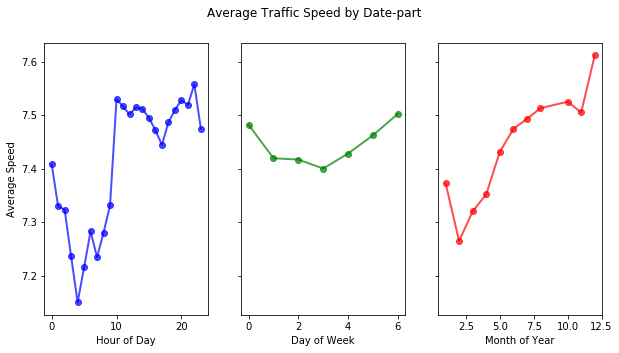

In [97]:
# Computing the mean speeds by observed distances/times 
x_train.loc[:, 'avg_speed_h'] = x_train['OSRM_estimated_distance'] / x_train['OSRM_estimated_duration']
x_train.loc[:, 'avg_speed_m'] =  x_train['OSRM_estimated_distance'] / x_train['OSRM_estimated_duration']

# Plot 
fig, ax = plt.subplots(ncols=3, sharey=True,figsize=(10,5))
ax[0].plot(x_train.groupby('hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(x_train.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(x_train.groupby('month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

A lot of differences appear according to which day of week it is

### Visualizing y_train

In [98]:
# selection-departure time vector
y_train_selection=np.array(y_train[['delta_selection-departure']]).flatten()
# departure-presentation time vector
y_train_presentation=np.array(y_train[['delta_departure-presentation']]).flatten()

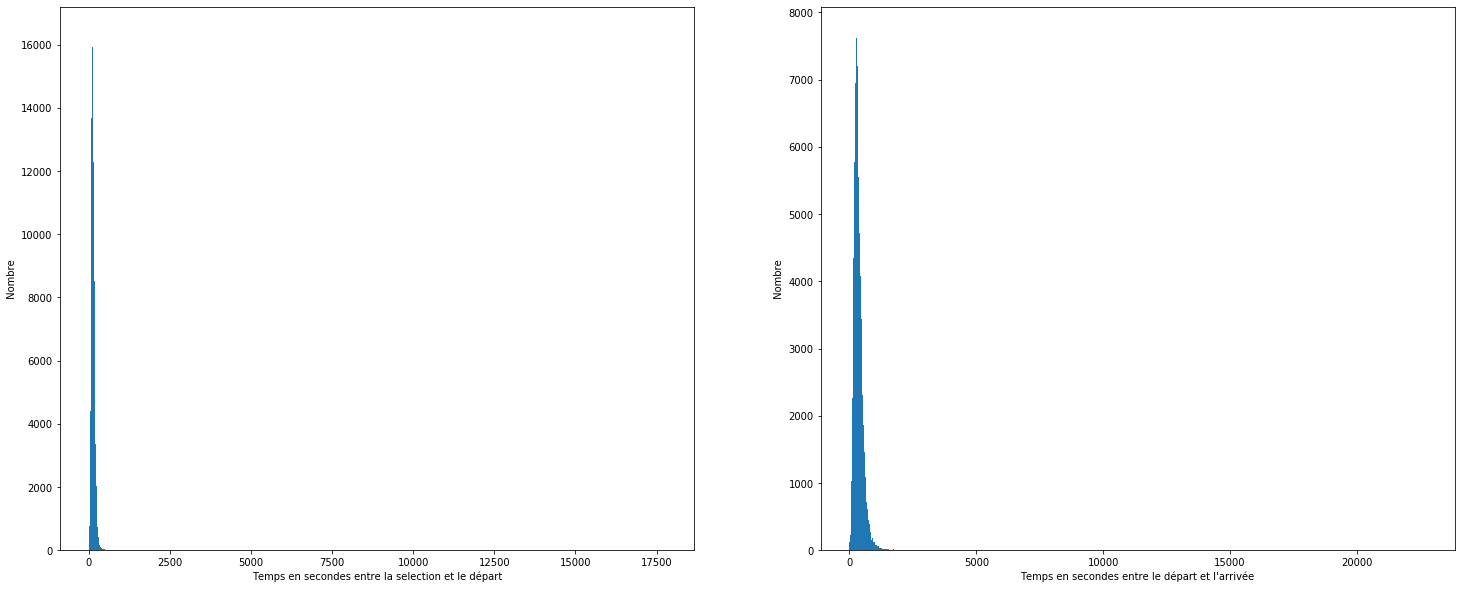

In [99]:
f, ax = plt.subplots(ncols=2,figsize=(25,10))
ax[0].hist(y_train_selection.flatten(),bins=2000)

ax[1].hist(y_train_presentation.flatten(),bins=2000)
#ax[1].hist(np.log(y_train_selection+1).flatten(),bins=2000)

#ax[0].set_xlim(0, 1000)
#ax[1].set_xlim(0, 2000)
ax[0].set_xlabel('Temps en secondes entre la selection et le départ')
ax[1].set_xlabel("Temps en secondes entre le départ et l'arrivée")

ax[0].set_ylabel(' Nombre ')
ax[1].set_ylabel(' Nombre ')


plt.show()

In [100]:
y_train.head()

,emergency_vehicle_selection,delta_selection-departure,delta_departure-presentation,delta_selection-presentation
0,5105452,86,324,410
1,4720915,164,297,461
2,5365374,125,365,490
3,4741586,168,160,328
4,5381209,138,523,661


### Data cleaning

In [101]:
Master=pd.concat([x_train,y_train['delta_selection-departure'],y_train['delta_departure-presentation'],
                y_train['delta_selection-presentation']],axis=1)

## outliers
aberrantes=Master[Master['delta_selection-departure'] >= 600]
aberrantes=Master[Master['delta_departure-presentation'] >= 2000]
## inliers
Master = Master[Master['delta_selection-departure'] <= 600]
Master = Master[Master['delta_departure-presentation'] <= 2000]

y_train=pd.concat([Master['emergency_vehicle_selection'],Master['delta_selection-departure'],
                 Master['delta_departure-presentation'],Master['delta_selection-presentation']],
                 axis=1)
x_train=Master.drop(['delta_selection-departure','delta_departure-presentation','delta_selection-presentation'],
                   axis=1)

x_train.head()

,emergency_vehicle_selection,intervention,alert_reason_category,alert_reason,intervention_on_public_roads,floor,location_of_the_event,longitude_intervention,latitude_intervention,emergency_vehicle,...,OSRM_response,OSRM_estimated_distance,OSRM_estimated_duration,updated,date,hour,month,dayofweek,avg_speed_h,avg_speed_m
0,5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,482.810,1,2018-07-08,19,7,6,1.972826,1.972826
1,4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,...,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.200,0,2018-01-04,9,1,3,9.204359,9.204359
2,5365374,13675521,3,2163,0,2,139.0,2.258328,48.836759,4509,...,"{""code"":""Ok"",""routes"":[{""geometry"":""_cdiHo}zLm...",3026.4,557.323,1,2018-11-16,10,11,4,5.430244,5.430244
3,4741586,12695745,3,2162,0,0,136.0,2.393832,48.776526,5731,...,"{""code"":""Ok"",""routes"":[{""geometry"":""sywhH_pqMy...",1934.2,318.880,1,2018-01-15,0,1,0,6.065605,6.065605
4,5381209,13698743,3,2162,0,3,104.0,2.458610,48.875751,5623,...,"{""code"":""Ok"",""routes"":[{""geometry"":""wvfiHgn{Mj...",2706.7,719.983,1,2018-11-24,0,11,5,3.759394,3.759394


In [102]:
aberrantes.shape

(251, 36)

In [103]:
y_train.head()

,emergency_vehicle_selection,delta_selection-departure,delta_departure-presentation,delta_selection-presentation
0,5105452,86,324,410
1,4720915,164,297,461
2,5365374,125,365,490
3,4741586,168,160,328
4,5381209,138,523,661


In [104]:
print(y_train.shape,x_train.shape)

(218984, 4) (218984, 33)


### Dummy variables

In [105]:
# Creation of dummy variables for both samples (test and train) - 0/1 indicators

month_train = pd.get_dummies(x_train['month'], prefix='m', prefix_sep='_')
dofw_train = pd.get_dummies(x_train['dayofweek'], prefix='d', prefix_sep='_')
hour_train = pd.get_dummies(x_train['hour'], prefix='h', prefix_sep='_')
emergency_train=pd.get_dummies(x_train['emergency_vehicle_type'], prefix='type', prefix_sep='_')
alert_reason_train = pd.get_dummies(x_train['alert_reason_category'], prefix='reason', prefix_sep='_')

month_test = pd.get_dummies(x_test['month'], prefix='m', prefix_sep='_')
dofw_test = pd.get_dummies(x_test['dayofweek'], prefix='d', prefix_sep='_')
hour_test = pd.get_dummies(x_test['hour'], prefix='h', prefix_sep='_')
emergency_test=pd.get_dummies(x_test['emergency_vehicle_type'], prefix='type', prefix_sep='_')
alert_reason_test = pd.get_dummies(x_test['alert_reason_category'], prefix='reason', prefix_sep='_')

In [106]:
updated.shape

(108033,)

In [107]:
emergency_train.head()

,type_AR,type_BEAA BSPP,type_CA,type_CCR BSPP,type_CD BSPP,type_CESD,type_CFS,type_CMO APP,type_CRAC,type_CRF,...,type_VRCP,type_VRM,type_VRSD,type_VSAV BALA,type_VSAV BSPP,type_VSAV SDIS,type_VSAV SSLIA,type_VSIS,type_VSTI,type_VTBA
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [108]:
print(month_test.columns.shape,month_train.columns.shape)
print(dofw_test.columns.shape,dofw_train.columns.shape)
print(hour_test.columns.shape,hour_train.columns.shape)
print(emergency_test.columns.shape,emergency_train.columns.shape)
print(alert_reason_test.columns.shape,alert_reason_train.columns.shape)

(11,) (11,)
(7,) (7,)
(24,) (24,)
(66,) (74,)
(9,) (9,)


There seems to be a slight issue for $\texttt{emergency}$

### Creation of training and testing datasets with desired features

In [109]:
temps_estimee=x_train['OSRM_estimated_duration']
distance=x_train['OSRM_estimated_distance']

Train_Master=pd.concat([x_train['OSRM_estimated_duration'],x_train['OSRM_estimated_distance'],
                        month_train,hour_train,alert_reason_train,x_train['updated'],
                       x_train['floor'],x_train['intervention_on_public_roads'],
                       dofw_train,x_train['delta_status_preceding_selection-selection'],
                       x_train['location_of_the_event'],x_train['rescue_center']],axis=1)

Test_Master=pd.concat([x_test['OSRM_estimated_duration'],x_test['OSRM_estimated_distance'],
                        month_test,hour_test,alert_reason_test,x_test['updated'],
                       x_test['floor'],x_test['intervention_on_public_roads'],
                       dofw_test,x_test['delta_status_preceding_selection-selection'],
                       x_test['location_of_the_event'],x_test['rescue_center']],axis=1)

In [110]:
Train_Master.head()

,OSRM_estimated_duration,OSRM_estimated_distance,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,...,d_0,d_1,d_2,d_3,d_4,d_5,d_6,delta_status_preceding_selection-selection,location_of_the_event,rescue_center
0,482.810,952.5,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,2027,148.0,2447
1,243.200,2238.5,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,28233,136.0,2464
2,557.323,3026.4,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1981,139.0,2438
3,318.880,1934.2,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1842,136.0,2510
4,719.983,2706.7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2716,104.0,2478


# 3. Implementation of the models

### Polynomial regression implementation

This is the starting code provided by the challenge organizer

In [ ]:
# Data reading
x_train_transit = x_train[['OSRM estimated distance','intervention on public roads','floor']]
y_train_transit = y_train[['delta departure-presentation']]
x_test_transit = x_test[['OSRM estimated distance','intervention on public roads','floor']]

# Create a predictive model for the 'delta departure-presentation'
# based on 'OSRM estimated distance', 'intervention on public roads' and 'floor'
polynomial_features= PolynomialFeatures(degree=3)
x_train_transit_poly = polynomial_features.fit_transform(x_train_transit)
model = LinearRegression()
model.fit(x_train_transit_poly, y_train_transit)

# Prediction of the 'delta selection-presentation'
x_test_transit_poly = polynomial_features.fit_transform(x_test_transit)
y_selection_presentation_predicted = y_train['delta selection-departure'].median() + model.predict(x_test_transit_poly)

# Create a submission file
submission = pd.concat([pd.DataFrame(x_test[['emergency vehicle selection']].values), 
           pd.DataFrame(np.full((len(x_test), 1), y_train['delta selection-departure'].median())), 
           pd.DataFrame(model.predict(x_test_transit_poly)), 
           pd.DataFrame(y_selection_presentation_predicted)], 
           axis=1)

submission.columns = list(y_train.columns.values)
submission.set_index('emergency vehicle selection', inplace=True)
submission.to_csv('./submission.csv', sep=",")

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
plt.hist(y_selection_presentation_predicted, bins=50)
plt.xlabel('Temps en secondes')
plt.ylabel('Nombre ')
plt.plot()

### Lasso implementation

In [111]:
Train_Lasso=Train_Master.drop(['location_of_the_event'],axis=1)
Test_Lasso=0
Test_Lasso=Test_Master.drop(['location_of_the_event'],axis=1)
Test_Lasso.head()

,OSRM_estimated_duration,OSRM_estimated_distance,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,...,intervention_on_public_roads,d_0,d_1,d_2,d_3,d_4,d_5,d_6,delta_status_preceding_selection-selection,rescue_center
0,336.500,3266.8,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,953,2483
1,466.503,2710.3,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1906,2462
2,85.100,914.2,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,654,2482
3,167.800,1124.2,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,10816,2450
4,244.000,1542.7,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,3219,2493


In [112]:
y_transit_selection=y_train['delta_selection-departure']
y_transit_presentation=y_train['delta_departure-presentation']
X_train, X_test, Y_train, Y_test=train_test_split(Train_Lasso, y_transit_selection, test_size=0.20)

In [113]:
print(Train_Lasso.shape,y_transit_selection.shape)

(218984, 58) (218984,)


In [114]:
from sklearn.linear_model import Lasso

model_lasso=Lasso(alpha=0.001)
model_lasso.fit(X_train,Y_train)
Y_pred=model_lasso.predict(X_test)

In [115]:
r2_score(Y_test,Y_pred)

0.19735085849795964

In [116]:
print(Train_Lasso.shape,Test_Lasso.shape)

(218984, 58) (108033, 58)


We now create the Y_test dataset

In [117]:
y_transit_selection=y_train['delta_selection-departure']
y_transit_presentation=y_train['delta_departure-presentation']

# For selection
model_lasso=Lasso(alpha=0.1)
model_lasso.fit(Train_Lasso,y_transit_selection)
Y_selection_pred=model_lasso.predict(Test_Lasso)

# For presentation
model_lasso_=Lasso(alpha=0.1)
model_lasso.fit(Train_Lasso,y_transit_presentation)
Y_presentation_pred=model_lasso.predict(Test_Lasso)
Y_pred=Y_selection_pred+Y_presentation_pred

In [118]:
Test_Lasso.shape

(108033, 58)

In [119]:
# Create a submission file
submission = pd.concat([pd.DataFrame(x_test['emergency_vehicle_selection'].values), \
           pd.DataFrame(Y_selection_pred), \
           pd.DataFrame(Y_presentation_pred), \
           pd.DataFrame(Y_pred)], \
           axis=1)

submission.columns = list(y_train.columns.values)
submission.set_index('emergency_vehicle_selection', inplace=True)
submission.to_csv('./Y_test_Lasso.csv', sep=",")

In [120]:
submission.head()

,delta_selection-departure,delta_departure-presentation,delta_selection-presentation
emergency_vehicle_selection,,,
5271704,125.140627,428.700075,553.840703
5092931,117.241649,340.932911,458.174560
5153756,118.313079,226.538743,344.851823
5355572,184.627913,301.930832,486.558745
5178915,131.541895,309.846298,441.388193


### XGBoost implementation

In [121]:
# selection-departure
y_train_selection=np.array(y_train[['delta_selection-departure']]).flatten()
# departure-presentation
y_train_presentation=np.array(y_train[['delta_departure-presentation']]).flatten()

# for selection_departure model
X_Train1, X_Test1, Y_Train1,Y_Test1 = train_test_split(Train_Master,y_train_selection, test_size = 0.1)

# for departure_presentation model
X_Train2, X_Test2, Y_Train2,Y_Test2 = train_test_split(Train_Master,y_train_presentation, test_size = 0.1)

In [122]:
import xgboost as xgb

# Conversion of the training and validation data into DMatrix (type required for xgb to work)
dtrain1 = xgb.DMatrix(X_Train1, label=Y_Train1)
dvalid1 = xgb.DMatrix(X_Test1, label=Y_Test1)
watchlist1 = [(dtrain1, 'train'), (dvalid1, 'valid')]

dtrain2 = xgb.DMatrix(X_Train2, label=Y_Train2)
dvalid2 = xgb.DMatrix(X_Test2, label=Y_Test2)
watchlist2 = [(dtrain2, 'train'), (dvalid2, 'valid')]

dtest= xgb.DMatrix(Test_Master)

We now train the model

In [123]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.3, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 2, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}

# selection-departure model
model1 = xgb.train(xgb_pars, dtrain1, 50, watchlist1, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model1.best_score)

# departure-presentation model
model2 = xgb.train(xgb_pars, dtrain2, 50, watchlist2, early_stopping_rounds=5,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model2.best_score)

[0]	train-rmse:110.525	valid-rmse:109.968
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:85.7393	valid-rmse:85.1563
[2]	train-rmse:70.2816	valid-rmse:69.6969
[3]	train-rmse:61.0132	valid-rmse:60.4276
[4]	train-rmse:55.7722	valid-rmse:55.2308
[5]	train-rmse:52.7005	valid-rmse:52.1145
[6]	train-rmse:51.122	valid-rmse:50.599
[7]	train-rmse:50.2525	valid-rmse:49.7584
[8]	train-rmse:49.5052	valid-rmse:49.0552
[9]	train-rmse:49.1657	valid-rmse:48.7702
[10]	train-rmse:48.9284	valid-rmse:48.5342
[11]	train-rmse:48.6431	valid-rmse:48.2762
[12]	train-rmse:48.5227	valid-rmse:48.1993
[13]	train-rmse:48.4154	valid-rmse:48.1166
[14]	train-rmse:48.215	valid-rmse:47.9388
[15]	train-rmse:48.1164	valid-rmse:47.8761
[16]	train-rmse:48.06	valid-rmse:47.824
[17]	train-rmse:47.9462	valid-rmse:47.7358
[18]	train-rmse:47.8879	valid-rmse:47.7232
[19]	train-rmse:47.8411	valid-rmse:47.7096
[20]	train-r

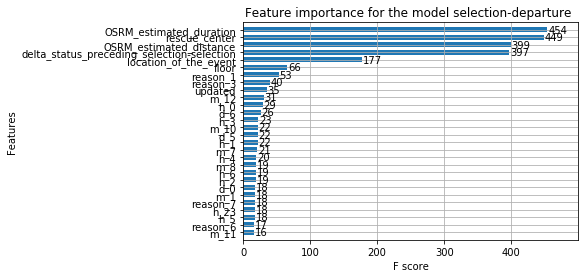

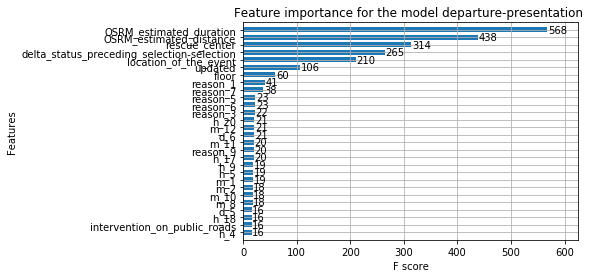

In [124]:
# plots of the features' importances
xgb.plot_importance(model1, max_num_features=28, height=0.7,
                    title='Feature importance for the model selection-departure ')

xgb.plot_importance(model2, max_num_features=28, height=0.7,
                    title='Feature importance for the model departure-presentation ')

Prediction with the trained models

In [125]:
# selection_departure prediction
pred_selec = model1.predict(dvalid1)

# departure-presentation prediction
pred_presentation = model2.predict(dvalid2)

print(pred_selec.shape,pred_presentation.shape,Y_Test1.shape,Y_Test2.shape)

(21899,) (21899,) (21899,) (21899,)


In [126]:
# Gathering the total prediction
Y_pred=pred_selec+pred_presentation
Y_valid=Y_Test1+Y_Test2

In [127]:
# Printing the r2 scores
print("Le r2_score pour le modèle selection_departure est:",r2_score(Y_Test1,pred_selec))
print("Le r2_score pour le modèle departure_presentation est:",r2_score(Y_Test2,pred_presentation))
print("Le r2_score total est:",r2_score(Y_valid,Y_pred))

Le r2_score pour le modèle selection_departure est: 0.2793175024689608
Le r2_score pour le modèle departure_presentation est: 0.4885226327047262
Le r2_score total est: 0.46926861328882985


[]

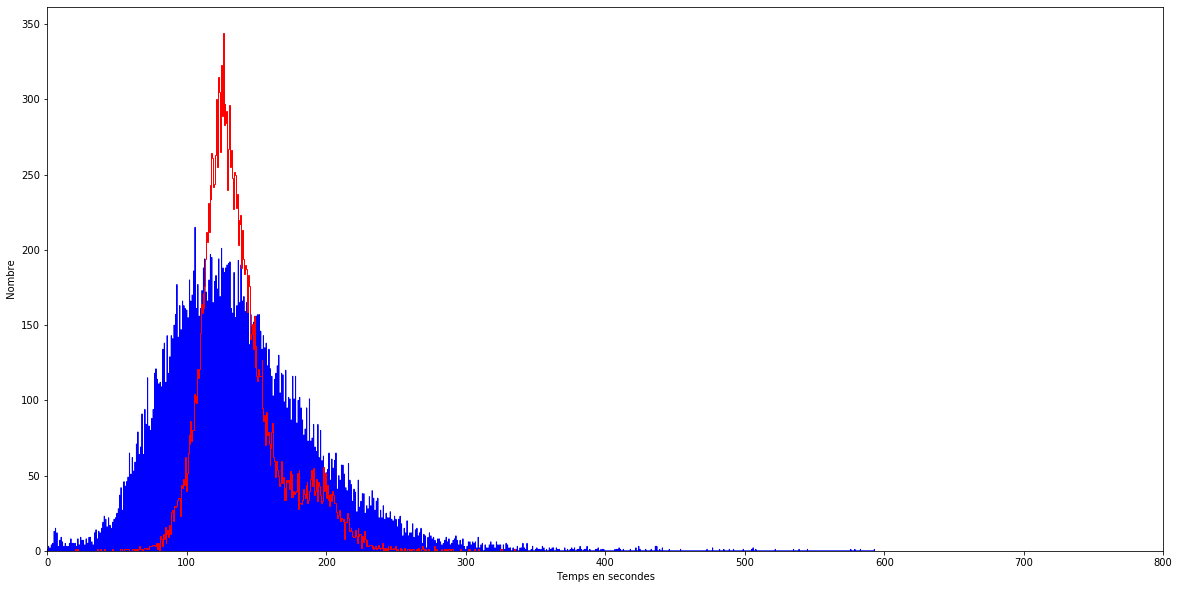

In [128]:
# Profile of the predictions
f, ax = plt.subplots(figsize=(20,10))
plt.hist(Y_Test1,bins=7000,color='blue',histtype='step')
plt.hist(pred_selec,bins=500,color='red',histtype='step')
ax.set_xlim(0,800)
plt.xlabel('Temps en secondes')
plt.ylabel(' Nombre ')
plt.plot()

We now generate the Y_test

In [129]:
Y_Test_selection_pred = model1.predict(dtest)
Y_Test_presentation_pred= model2.predict(dtest)
Y_Test_pred=Y_Test_selection_pred+Y_Test_presentation_pred

print(Y_Test_pred.shape)

(108033,)


In [130]:
# Create a submission file
submission = pd.concat([pd.DataFrame(x_test['emergency_vehicle_selection'].values), \
           pd.DataFrame(Y_Test_selection_pred), \
           pd.DataFrame(Y_Test_presentation_pred), \
           pd.DataFrame(Y_Test_pred)], \
           axis=1)

submission.columns = list(y_train.columns.values)
submission.set_index('emergency_vehicle_selection', inplace=True)
submission.to_csv('./Y_test_xgb.csv', sep=",")

### XGBoost implementation with prior logarithmic transformation

In [131]:
# selection-departure time vector
y_train_selection=np.array(y_train[['delta_selection-departure']]).flatten()
# departure-presentation time vector
y_train_presentation=np.array(y_train[['delta_departure-presentation']]).flatten()

# logarithmic transformation
y_train_selection=np.log(y_train_selection+1)
y_train_presentation=np.log(y_train_presentation+1)

# For selection-departure model
X_Train1, X_Test1, Y_Train1,Y_Test1 = train_test_split(Train_Master,y_train_selection, test_size = 0.2)

# For departure_presentation model
X_Train2, X_Test2, Y_Train2,Y_Test2 = train_test_split(Train_Master,y_train_presentation, test_size = 0.2)

In [132]:
# Conversion of the training and validation data into DMatrix (type required for xgb to work)
dtrain1 = xgb.DMatrix(X_Train1, label=Y_Train1)
dvalid1 = xgb.DMatrix(X_Test1, label=Y_Test1)
watchlist1 = [(dtrain1, 'train'), (dvalid1, 'valid')]


dtrain2 = xgb.DMatrix(X_Train2, label=Y_Train2)
dvalid2 = xgb.DMatrix(X_Test2, label=Y_Test2)
watchlist2 = [(dtrain2, 'train'), (dvalid2, 'valid')]

We now train the model

In [133]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.3, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 2, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}

# selection-departure model
model1 = xgb.train(xgb_pars, dtrain1, 50, watchlist1, early_stopping_rounds=5,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model1.best_score)

# departure-presentation model
model2 = xgb.train(xgb_pars, dtrain2, 50, watchlist2, early_stopping_rounds=5,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model2.best_score)

[0]	train-rmse:3.07537	valid-rmse:3.07556
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[1]	train-rmse:2.17388	valid-rmse:2.17446
[2]	train-rmse:1.55084	valid-rmse:1.55178
[3]	train-rmse:1.1259	valid-rmse:1.12767
[4]	train-rmse:0.842031	valid-rmse:0.84485
[5]	train-rmse:0.65906	valid-rmse:0.663177
[6]	train-rmse:0.54565	valid-rmse:0.551276
[7]	train-rmse:0.479618	valid-rmse:0.486424
[8]	train-rmse:0.443727	valid-rmse:0.4516
[9]	train-rmse:0.424143	valid-rmse:0.432735
[10]	train-rmse:0.413381	valid-rmse:0.422466
[11]	train-rmse:0.406998	valid-rmse:0.416708
[12]	train-rmse:0.403896	valid-rmse:0.414074
[13]	train-rmse:0.402133	valid-rmse:0.412691
[14]	train-rmse:0.400869	valid-rmse:0.41174
[15]	train-rmse:0.400047	valid-rmse:0.411131
[16]	train-rmse:0.398519	valid-rmse:0.409805
[17]	train-rmse:0.398119	valid-rmse:0.409579
[18]	train-rmse:0.397636	valid-rmse:0.409309
[19]	train-rmse:0.397194	v

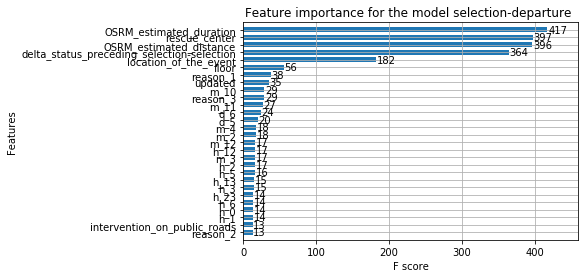

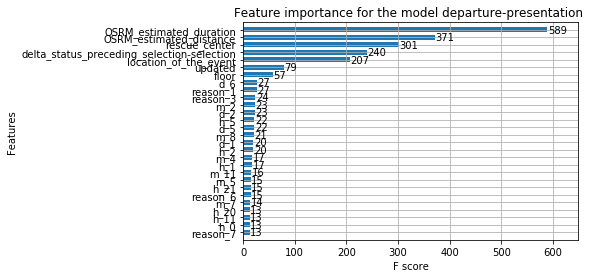

In [134]:
# plots of the features' importances
xgb.plot_importance(model1, max_num_features=28, height=0.7,
                    title='Feature importance for the model selection-departure ')

xgb.plot_importance(model2, max_num_features=28, height=0.7,
                    title='Feature importance for the model departure-presentation ')

Prediction with the trained models

In [135]:
# selection_departure prediction and applying the exponential function
pred_selec = model1.predict(dvalid1)
pred_selec=np.exp(pred_selec)-1

# prediction departure-presentation
pred_presentation = model2.predict(dvalid2)
pred_presentation=np.exp(pred_presentation)-1

# applying the exponential funciton to Y_Test
Y_Test1=np.exp(Y_Test1)-1
Y_Test2=np.exp(Y_Test2)-1

print(pred_selec.shape,pred_presentation.shape,Y_Test1.shape,Y_Test2.shape)

(43797,) (43797,) (43797,) (43797,)


In [136]:
# Gathering the total prediction
Y_pred=pred_selec+pred_presentation
Y_Test=Y_Test1+Y_Test2

In [137]:
# Printing the r2 scores
print("Le r2_score pour le modèle selection_departure est:",r2_score(Y_Test1,pred_selec))
print("Le r2_score pour le modèle departure_presentation est:",r2_score(Y_Test2,pred_presentation))
print("Le r2_score total est:",r2_score(Y_Test,Y_pred))

Le r2_score pour le modèle selection_departure est: 0.23734889762020728
Le r2_score pour le modèle departure_presentation est: 0.472822677215883
Le r2_score total est: 0.4450038226020183


The results with this transformation are fairly worse

# 4. Data engineering and advanced visualization

### Exporting the data into a database

In [138]:
# Establishing the connection with pgsql database
conn = psycopg2.connect(os.environ['DB_POMPIERS_URL'])
cur = conn.cursor()

In [139]:
def to_table_key(s): return (s.replace(' ','_').replace('-','_')).lower()
def to_exportable_df(df):
    old_cols = df.columns.tolist()
    new_cols = map(lambda x: to_table_key(x), old_cols)
    d_chcols = {k:v for (k,v) in zip(old_cols, new_cols)}
    return d_chcols

def export_df(df, name, schema="data"):
    df = df.rename(columns=to_exportable_df(df))
    engine = create_engine(os.environ['DB_POMPIERS_URL'])
    df.to_sql(name, engine, schema, if_exists='replace', index=False)

In [140]:
# Normalization of the dfs names
x_train = x_train.rename(columns=to_exportable_df(x_train))
x_test = x_test.rename(columns=to_exportable_df(x_test))
y_train = y_train.rename(columns=to_exportable_df(y_train))
x_test_add = x_test_add.rename(columns=to_exportable_df(x_test_add))
x_train_add = x_train_add.rename(columns=to_exportable_df(x_train_add))

In [ ]:
# Tests if the features names written in features.csv
# match with the ones provided in the training files
features = pd.read_csv('features.csv', sep=';')
l1 = x_train.columns.tolist()+y_train.columns.tolist()+x_train_add.columns.tolist()
l2 = features['feature_name'].tolist()
test = [(feat1==feat2, feat1, feat2) for (feat1, feat2) in zip(l1, l2) if feat1 != feat2]
print(len(test)==0)

In [ ]:
# Exporting the data into the local database
cur.execute('CREATE SCHEMA IF NOT EXISTS data')
conn.commit()

dg = pd.DataFrame()

for df_name in ['x_train', 'y_train', 'x_test', 'x_train_add', 'x_test_add']:
    dg  = eval(df)
    export_df(dg, df_name, "data")

### Generation of a map for itineraries data visualization

In [142]:
import json
import requests
import polyline, geojson
from pprint import pprint
from ipyleaflet import Map, basemaps, basemap_to_tiles, GeoJSON, Polyline, CircleMarker
from geojson import LineString, Point, Feature
from ipywidgets import Layout
defaultLayout=Layout(width='960px', height='600px')

# Takes an address located in France (str)
# Returns its coordinates ['lon', 'lat']
def geocode(address, lon=2.352222, lat=48.856613, tp="housenumber"):
    add = address.replace(' ','+').lower()
    url = "https://api-adresse.data.gouv.fr/search/?q={ADD}&lat={LAT}&lon={LON}&type={TP}&limit=1".format(
        ADD=add, LAT=lat, LON=lon, TP=tp)
    response = requests.get(url)
    return json.loads(response.text)['features'][0]['geometry']['coordinates']

# Takes two lists of coordinates of points located in Paris area ([float, float], [float, float])
# Returns the Polyline route of the fastest track calculated by ORSM (Polyline)
def route(lonlat1, lonlat2=[2.352222, 48.856613], how='car'):
    url = "http://0.0.0.0:5000/route/v1/{HOW}/{LON1},{LAT1};{LON2},{LAT2}".format(
        HOW=how, LON1=lonlat1[0], LAT1=lonlat1[1], LON2=lonlat2[0], LAT2=lonlat2[1])
    response = requests.get(url)
    return json.loads(response.text)['routes'][0]['geometry']

# Returns a customized ipyleaflet CircleMarker
def cmarker(color="#0033FF", location=[0,0], radius=10, stroke=True, opacity=1.0, weight=5, fill=True,
            fill_color="#0033FF", fill_opacity=0.2):
    c = CircleMarker()
    c.color = color
    c.location = location
    c.radius = radius
    c.stroke = stroke
    c.opacity = opacity
    c.weight = weight
    c.fill = fill
    c.fill_color = fill_color
    c.fill_opacity = fill_opacity
    return c

# Takes two locations located in Paris area (str, str)
# Returns a map centered on the departure address with the plot of the fastest route
def gps_track(departure, destination, lonlat_inputs=False):
    if not lonlat_inputs:
        lonlat1 = geocode(departure)
        lonlat2 = geocode(destination)
    else:
        lonlat1 = departure
        lonlat2 = destination
    track = polyline.decode(route(lonlat1, lonlat2), geojson=True)
    line = GeoJSON(data=LineString(track), style = {'color': 'blue', 'opacity':0.6, 'weight':5, 'fillOpacity':0.1})
    m = Map(layers=(basemap_to_tiles(basemaps.Hydda.Full, "2019-11-19"),),
            layout=defaultLayout,
            center=(lonlat1[1], lonlat1[0]),
            zoom=14)
    m.add_layer(line)
    pt_departure = cmarker(color="#4abd0b", fill_color="#4abd0b", location=lonlat1[::-1], radius=10, weight=2)
    pt_destination = cmarker(color="#de0000", fill_color="#de0000", location=lonlat2[::-1], radius=10, weight=2)
    m.add_layer(pt_departure)
    m.add_layer(pt_destination)    
    return m

months = {'01': 'january', '02': 'february', '03': 'march', '04': 'april', '05': 'may', '06': 'june',
         '07': 'july', '08': 'august', '09': 'september', '10': 'october', '11': 'november', '12': 'december'}

In [143]:
# Takes a vehicle id of the testing dataset and plots its true and predicted itinerary
def visualize_intervention(vid):
    x = x_train.loc[x_train['emergency vehicle selection']==vid].iloc[0].to_dict()
    y = y_train.loc[y_train['emergency vehicle selection']==vid].iloc[0].to_dict()
    
    # Getting travel information
    date = str(x['date key sélection'])
    time = str(x['time key sélection'])
    time = (6-len(time))*'0'+time
    
    print("Visualization of intervention n°{VID}".format(VID=vid))
    print("{DD} {MM} {YYYY}, {HH}:{MT}:{SS}".format(DD=date[6:], MM=months[date[4:6]].capitalize(), YYYY=date[:4],
                                                   HH=time[:2], MT=time[2:4], SS=time[4:]))
    print("--------------------------------------------------------------------------")
    print("Estimated distance :", x['OSRM estimated distance'])
    print("Estimated transit duration :", x['OSRM estimated duration'])
    print("Actual transit duration :", y['delta departure-presentation'])
    print("Actual total duration :", y['delta selection-presentation'])
    
    # Retrieving tracks
    est_track = polyline.decode(eval(x['OSRM response'])['routes'][0]['geometry'], geojson=True)
    try:
        true_track = list(map(lambda l: (float(l.split(',')[0]), float(l.split(',')[1])),
                              x['GPS tracks departure-presentation'].split(';')))
    except AttributeError:
        true_track = []
        print("--------------------------------------------------------------------------")
        print("No GPS track was recorded for this intervention")
    
    dept=[x['latitude before departure'], x['longitude before departure']]
    dest=[x['latitude intervention'], x['longitude intervention']]

    # Generating layers
    est_line = GeoJSON(data=LineString(est_track),
                       style = {'color': 'purple', 'opacity':0.6, 'weight':5,'dashArray':7, 'fillOpacity':0.1})
    true_line = GeoJSON(data=LineString(true_track),
                       style = {'color': 'blue', 'opacity':0.6, 'weight':5, 'fillOpacity':0.1})
    
    pt_departure = cmarker(color="#4abd0b", fill_color="#4abd0b", location=dept, radius=10, weight=2)
    pt_destination = cmarker(color="#de0000", fill_color="#de0000", location=dest, radius=10, weight=2)
    
    # Generating map and adding layers
    m = Map(layers=(basemap_to_tiles(basemaps.Hydda.Full, "2019-11-19"),),
                layout=defaultLayout,
                center=dept,
                zoom=14)
    m.add_layer(est_line)
    m.add_layer(true_line)
    m.add_layer(pt_departure)
    m.add_layer(pt_destination)  
    
    display(m)

In [144]:
from random import randint

# In this section, x_train and y_train are reloaded and therefore may not have the same features as before
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')

# Plot a random selection among x_train entries that have a recorded GPS track
vids = x_train.loc[~pd.isna(x_train['GPS tracks departure-presentation'])]['emergency vehicle selection'].to_list()
i = vids[randint(0, len(vids)-1)]

visualize_intervention(i)

Visualization of intervention n°4763017
25 January 2018, 16:02:08
--------------------------------------------------------------------------
Estimated distance : 4525.0
Estimated transit duration : 452.4
Actual transit duration : 370
Actual total duration : 500


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Another (unrelated) piece of code

This function is not directly related to this project. Its purpose is to geocode addresses located in Quebec (Canada) to use the routing functionalities in this country. Just made for fun.
> To use it, just replace the geocode function by the one below in $\texttt{gps_track}$()

In [ ]:
# Takes an address located in Quebec (str)
def geocode_qc(address):
    add = address.replace(' ','+').lower()
    url = "https://geocoder.ca/?locate={ADD}&json=1".format(ADD=add)
    response = requests.get(url)
    return [json.loads(response.text)["longt"],json.loads(response.text)["latt"]]